In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/molecule-processed/processed_output.csv
/kaggle/input/molecular-activity-and-chemical-reaction/raw_val.csv
/kaggle/input/molecular-activity-and-chemical-reaction/raw_test.csv
/kaggle/input/molecular-activity-and-chemical-reaction/raw_train.csv


In [13]:
df=pd.read_csv("/kaggle/input/molecule-processed/processed_output.csv")

In [71]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/kaggle/input/molecule-processed/processed_output.csv")  # replace with actual path
print("✅ CSV loaded. Columns:", df.columns.tolist())
print("🔍 Sample rows:")
print(df[['input_smiles', 'output_smiles', 'input_tokens', 'output_tokens']].head(2))


✅ CSV loaded. Columns: ['id', 'class', 'reactants>reagents>production', 'input_smiles', 'output_smiles', 'input_tokens', 'output_tokens']
🔍 Sample rows:
                                        input_smiles  \
0  O=C(O[C:1](=[O:2])[C:3]([F:4])([F:5])[F:6])C(F...   
1  CC(C)(C)OC(=O)O[C:6]([O:5][C:2]([CH3:1])([CH3:...   

                                       output_smiles  \
0  [C:1](=[O:2])([C:3]([F:4])([F:5])[F:6])[NH:7][...   
1  [CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...   

                                        input_tokens  \
0  ['O', '=', 'C', '(', 'O', '[C:1]', '(', '=', '...   
1  ['C', 'C', '(', 'C', ')', '(', 'C', ')', 'O', ...   

                                       output_tokens  
0  ['[C:1]', '(', '=', '[O:2]', ')', '(', '[C:3]'...  
1  ['[CH3:1]', '[C:2]', '(', '[CH3:3]', ')', '(',...  


In [72]:
import ast

# Safely convert stringified lists to actual Python lists
df['input_tokens'] = df['input_tokens'].apply(ast.literal_eval)
df['output_tokens'] = df['output_tokens'].apply(ast.literal_eval)

print("🔍 Sample converted token list:")
print("Input:", df['input_tokens'].iloc[0][:10])
print("Output:", df['output_tokens'].iloc[0][:10])


🔍 Sample converted token list:
Input: ['O', '=', 'C', '(', 'O', '[C:1]', '(', '=', '[O:2]', ')']
Output: ['[C:1]', '(', '=', '[O:2]', ')', '(', '[C:3]', '(', '[F:4]', ')']


In [73]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Flatten all tokens
all_input_tokens = [token for sublist in df['input_tokens'] for token in sublist]
all_output_tokens = [token for sublist in df['output_tokens'] for token in sublist]

# Initialize tokenizer with OOV token
tokenizer = Tokenizer(filters='', lower=False, oov_token='<unk>')
tokenizer.fit_on_texts(all_input_tokens + all_output_tokens)

# Save vocab size (add 1 for padding token at index 0)
vocab_size = len(tokenizer.word_index) + 1
print(f"✅ Vocab size (including <unk> and padding): {vocab_size}")

# Convert token lists to ID sequences
input_token_ids = tokenizer.texts_to_sequences(df['input_tokens'])
output_token_ids = tokenizer.texts_to_sequences(df['output_tokens'])

# Shifted decoder inputs (remove last token from output), and targets (remove first)
decoder_input_ids = [seq[:-1] for seq in output_token_ids]
decoder_target_ids = [seq[1:] for seq in output_token_ids]

# Show an example
print("🔢 Tokenized Input Example:", input_token_ids[0][:10])
print("🔢 Tokenized Output Example:", output_token_ids[0][:10])


✅ Vocab size (including <unk> and padding): 1559
🔢 Tokenized Input Example: [10, 6, 8, 2, 10, 24, 2, 6, 61, 3]
🔢 Tokenized Output Example: [24, 2, 6, 61, 3, 2, 151, 2, 434, 3]


In [74]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# Padding
encoder_input_data = pad_sequences(input_token_ids, padding='post')
decoder_input_data = pad_sequences(decoder_input_ids, padding='post')
decoder_target_data = pad_sequences(decoder_target_ids, padding='post')

# Get shapes
print("📏 Encoder input shape:", encoder_input_data.shape)
print("📏 Decoder input shape:", decoder_input_data.shape)
print("📏 Decoder target shape (before one-hot):", decoder_target_data.shape)

# One-hot encode decoder targets
decoder_target_data = tf.keras.utils.to_categorical(decoder_target_data, num_classes=vocab_size)
print("✅ Decoder target shape (after one-hot):", decoder_target_data.shape)


📏 Encoder input shape: (5001, 130)
📏 Decoder input shape: (5001, 123)
📏 Decoder target shape (before one-hot): (5001, 123)
✅ Decoder target shape (after one-hot): (5001, 123, 1559)


In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

latent_dim = 256  # Size of LSTM hidden state

# --- Encoder ---
encoder_inputs = Input(shape=(None,), name='encoder_inputs')
enc_emb = Embedding(input_dim=vocab_size, output_dim=latent_dim, mask_zero=True)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

# --- Decoder ---
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
dec_emb = Embedding(input_dim=vocab_size, output_dim=latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# --- Model ---
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, None, 256)      │        399,104 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_9 (Embedding)   │ (None, None, 256)      │        399,104 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 256), (None,   │        525,312 │ embedding_8[0][0],     │
│                           │ 256), (None, 256)]     │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 256),    │        525,312 │ embedding_9[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, None, 1559)     │        400,663 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,249,495 (8.58 MB)

 Trainable params: 2,249,495 (8.58 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=20,
    validation_split=0.2
)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.0493 - loss: 5.7678 - val_accuracy: 0.0661 - val_loss: 4.5441
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.0712 - loss: 4.3704 - val_accuracy: 0.1034 - val_loss: 3.8846
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.1070 - loss: 3.7755 - val_accuracy: 0.1195 - val_loss: 3.4990
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.1222 - loss: 3.4048 - val_accuracy: 0.1358 - val_loss: 3.2050
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.1373 - loss: 3.1189 - val_accuracy: 0.1462 - val_loss: 2.9722
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.1453 - loss: 2.8899 - val_accuracy: 0.1528 - val_loss: 2.8041
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.1527 - loss: 2.7354 - val_accuracy: 0.1589 - val_loss: 2.6694
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.1593 - loss: 2.6019 - val_accuracy: 0.1662 - v

In [7]:
import pandas as pd
import ast

# CSV load karo
df = pd.read_csv('/kaggle/input/molecule-processed/processed_output.csv')

print("✅ CSV loaded. Columns:", list(df.columns))
print("🔍 Sample rows:")
print(df[['input_smiles', 'output_smiles', 'input_tokens', 'output_tokens']].head(2))

# stringified lists ko python lists me convert karo safely
df['input_tokens'] = df['input_tokens'].apply(ast.literal_eval)
df['output_tokens'] = df['output_tokens'].apply(ast.literal_eval)

print("\n🔍 Sample converted token list:")
print("Input:", df['input_tokens'].iloc[0][:10])
print("Output:", df['output_tokens'].iloc[0][:10])


✅ CSV loaded. Columns: ['id', 'class', 'reactants>reagents>production', 'input_smiles', 'output_smiles', 'input_tokens', 'output_tokens']
🔍 Sample rows:
                                        input_smiles  \
0  O=C(O[C:1](=[O:2])[C:3]([F:4])([F:5])[F:6])C(F...   
1  CC(C)(C)OC(=O)O[C:6]([O:5][C:2]([CH3:1])([CH3:...   

                                       output_smiles  \
0  [C:1](=[O:2])([C:3]([F:4])([F:5])[F:6])[NH:7][...   
1  [CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...   

                                        input_tokens  \
0  ['O', '=', 'C', '(', 'O', '[C:1]', '(', '=', '...   
1  ['C', 'C', '(', 'C', ')', '(', 'C', ')', 'O', ...   

                                       output_tokens  
0  ['[C:1]', '(', '=', '[O:2]', ')', '(', '[C:3]'...  
1  ['[CH3:1]', '[C:2]', '(', '[CH3:3]', ')', '(',...  

🔍 Sample converted token list:
Input: ['O', '=', 'C', '(', 'O', '[C:1]', '(', '=', '[O:2]', ')']
Output: ['[C:1]', '(', '=', '[O:2]', ')', '(', '[C:3]', '(', '[F:4]', ')']


In [ ]:
import numpy as np
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model

# Parameters
vocab_size = 1559
embedding_dim = 256
latent_dim = 256
max_encoder_seq_length = 130
max_decoder_seq_length = 124

# Dummy data for example (replace with your actual tokenized and padded data)
num_samples = 5000
encoder_input_data = np.random.randint(1, vocab_size, size=(num_samples, max_encoder_seq_length))
decoder_input_data = np.random.randint(1, vocab_size, size=(num_samples, max_decoder_seq_length))
decoder_target_data = np.random.randint(1, vocab_size, size=(num_samples, max_decoder_seq_length))

# Model
encoder_inputs = Input(shape=(None,), name='encoder_inputs')
enc_emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,), name='decoder_inputs')
dec_emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile with sparse_categorical_crossentropy
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
# Note: decoder_target_data shape (num_samples, timesteps), but Keras expects (num_samples, timesteps, 1) for sparse loss
model.fit(
    [encoder_input_data, decoder_input_data], 
    np.expand_dims(decoder_target_data, -1),  # add last dim for sparse_categorical_crossentropy
    batch_size=64,
    epochs=20,
    validation_split=0.2
)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 6.9102e-04 - loss: 7.3518 - val_accuracy: 6.6129e-04 - val_loss: 7.3518
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.0011 - loss: 7.3493 - val_accuracy: 6.7742e-04 - val_loss: 7.3523
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.0012 - loss: 7.3428 - val_accuracy: 7.7419e-04 - val_loss: 7.3551
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.0015 - loss: 7.3223 - val_accuracy: 6.3710e-04 - val_loss: 7.3658
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.0025 - loss: 7.2810 - val_accuracy: 7.3387e-04 - val_loss: 7.3896
Epoch 6/20
41/63 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.0035 - loss: 7.2218

In [10]:
import pandas as pd
import ast
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Bidirectional, Concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load and process data
df = pd.read_csv("/kaggle/input/molecule-processed/processed_output.csv")  # replace with your CSV path
df['input_tokens'] = df['input_tokens'].apply(ast.literal_eval)
df['output_tokens'] = df['output_tokens'].apply(ast.literal_eval)

input_texts = df['input_tokens'].tolist()
output_texts = [['<sos>'] + x + ['<eos>'] for x in df['output_tokens']]

# Tokenizer
tokenizer = Tokenizer(filters='', lower=False, oov_token='<unk>')
tokenizer.fit_on_texts(input_texts + output_texts)

input_sequences = tokenizer.texts_to_sequences(input_texts)
output_sequences = tokenizer.texts_to_sequences(output_texts)

max_encoder_len = max(len(seq) for seq in input_sequences)
max_decoder_len = max(len(seq) for seq in output_sequences)
vocab_size = len(tokenizer.word_index) + 1

# Padding
encoder_input_data = pad_sequences(input_sequences, maxlen=max_encoder_len, padding='post')
decoder_input_data = pad_sequences([seq[:-1] for seq in output_sequences], maxlen=max_decoder_len - 1, padding='post')
decoder_target_data = pad_sequences([seq[1:] for seq in output_sequences], maxlen=max_decoder_len - 1, padding='post')

# Model Architecture
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(vocab_size, latent_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = Bidirectional(LSTM(latent_dim, return_state=True, dropout=0.3, recurrent_dropout=0.3))
_, forward_h, forward_c, backward_h, backward_c = encoder_lstm(enc_emb)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(vocab_size, latent_dim * 2, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim * 2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Output layer
output_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = output_dense(decoder_outputs)

# Compile Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape target data for sparse loss
decoder_target_data = np.expand_dims(decoder_target_data, -1)

# Train
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=20,
    validation_split=0.1
)


Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 369s 5s/step - accuracy: 0.0561 - loss: 5.3558 - val_accuracy: 0.1065 - val_loss: 3.7011
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 373s 5s/step - accuracy: 0.1195 - loss: 3.5700 - val_accuracy: 0.1429 - val_loss: 3.0264
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 334s 5s/step - accuracy: 0.1501 - loss: 2.9635 - val_accuracy: 0.1662 - val_loss: 2.5875
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - accuracy: 0.1658 - loss: 2.5808 - val_accuracy: 0.1795 - val_loss: 2.3325
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - accuracy: 0.1795 - loss: 2.3274 - val_accuracy: 0.1901 - val_loss: 2.1379
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 339s 5s/step - accuracy: 0.1900 - loss: 2.1395 - val_accuracy: 0.1971 - val_loss: 1.9880
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - accuracy: 0.1957 - loss: 1.9823 - val_accuracy: 0.2060 - val_loss: 1.8585
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 336s 5s/step - accuracy: 0.2040 - loss: 1.8636 - val_accuracy: 0.2119 - v

In [20]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/kaggle/input/molecule-processed/processed_output.csv")  # make sure to replace with your file path

input_texts = df["input_tokens"].apply(eval).tolist()
target_texts = df["output_tokens"].apply(eval).tolist()

# Tokenizer
tokenizer = Tokenizer(oov_token="<unk>", filters="", lower=False)
tokenizer.fit_on_texts(input_texts + target_texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # include padding

# Convert to sequences
input_seqs = tokenizer.texts_to_sequences(input_texts)
target_seqs = tokenizer.texts_to_sequences(target_texts)

# Define max sequence length
max_len = 130

encoder_input_data = pad_sequences(input_seqs, maxlen=max_len, padding='post')
decoder_input_data = pad_sequences([seq[:-1] for seq in target_seqs], maxlen=max_len, padding='post')
decoder_target_data = pad_sequences([seq[1:] for seq in target_seqs], maxlen=max_len, padding='post')

# No one-hot needed — use sparse categorical loss
decoder_target_data = np.expand_dims(decoder_target_data, -1)

# Define model
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(None,), name="encoder_input")
enc_emb = Embedding(input_dim=vocab_size, output_dim=latent_dim, mask_zero=True)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,), name="decoder_input")
dec_emb = Embedding(input_dim=vocab_size, output_dim=latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Compile model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=20,
    validation_split=0.2
)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.0479 - loss: 5.7877 - val_accuracy: 0.0578 - val_loss: 4.5386
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.0661 - loss: 4.3781 - val_accuracy: 0.0945 - val_loss: 3.8786
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.0971 - loss: 3.7435 - val_accuracy: 0.1132 - val_loss: 3.4562
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.1145 - loss: 3.3621 - val_accuracy: 0.1313 - val_loss: 3.1571
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.1317 - loss: 3.0645 - val_accuracy: 0.1427 - val_loss: 2.9239
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.1416 - loss: 2.8627 - val_accuracy: 0.1503 - val_loss: 2.7586
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.1490 - loss: 2.6971 - val_accuracy: 0.1545 - val_loss: 2.6204
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.1537 - loss: 2.5617 - val_accuracy: 0.1598 - val_los

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Hyperparameters (Adjust based on your data)
vocab_size = 1559
embedding_dim = 256
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(None,), name="encoder_inputs")
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(encoder_inputs)
encoder_bi_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bi_lstm(encoder_embedding)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Decoder
decoder_inputs = Input(shape=(None,), name="decoder_inputs")
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim * 2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# Attention
attention_layer = Attention()
attention_output = attention_layer([decoder_outputs, encoder_outputs])
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Final output
decoder_dense = Dense(vocab_size, activation="softmax")
decoder_outputs = decoder_dense(decoder_concat)

# Compile the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_22 (Embedding)  │ (None, None, 256)      │        399,104 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_22 (NotEqual)   │ (None, None)           │              0 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ [(None, None, 512),    │      1,050,624 │ embedding_22[0][0],    │
│ (Bidirectional)           │ (None, 256), (None,    │                │ not_equal_22[0][0]     │
│                           │ 256), (None, 256),     │                │                        │
│                           │ (None, 256)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_23 (Embedding)  │ (None, None, 256)      │        399,104 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_22            │ (None, 512)            │              0 │ bidirectional_6[0][1], │
│ (Concatenate)             │                        │                │ bidirectional_6[0][3]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_23            │ (None, 512)            │              0 │ bidirectional_6[0][2], │
│ (Concatenate)             │                        │                │ bidirectional_6[0][4]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_23 (LSTM)            │ [(None, None, 512),    │      1,574,912 │ embedding_23[0][0],    │
│                           │ (None, 512), (None,    │                │ concatenate_22[0][0],  │
│                           │ 512)]                  │                │ concatenate_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_23 (NotEqual)   │ (None, None)           │              0 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, None, 512)      │              0 │ lstm_23[0][0],         │
│                           │                        │                │ bidirectional_6[0][0], │
│                           │                        │                │ not_equal_23[0][0],    │
│                           │                        │                │ not_equal_22[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_24            │ (None, None, 1024)     │              0 │ lstm_23[0][0],         │
│ (Concatenate)             │                        │                │ attention_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, None, 1559)     │      1,597,975 │ concatenate_24[0][0]   │
└──────────────────────

 Total params: 5,021,719 (19.16 MB)

 Trainable params: 5,021,719 (19.16 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from collections import Counter

# Load dataset
df = pd.read_csv('/kaggle/input/molecule-processed/processed_output.csv')  # path to your CSV
input_texts = df['input_tokens'].apply(eval).tolist()
target_texts = df['output_tokens'].apply(eval).tolist()

# Build token vocabulary
all_tokens = [token for sublist in input_texts + target_texts for token in sublist]
token_counts = Counter(all_tokens)
tokens = sorted(token_counts)
token_to_id = {token: idx + 1 for idx, token in enumerate(tokens)}  # 0 is reserved for padding
token_to_id['<unk>'] = len(token_to_id) + 1
id_to_token = {i: t for t, i in token_to_id.items()}
vocab_size = len(token_to_id) + 1

# Encode sequences
def encode(seq):
    return [token_to_id.get(tok, token_to_id['<unk>']) for tok in seq]

encoder_input_data = [encode(seq) for seq in input_texts]
decoder_target_data = [encode(seq) for seq in target_texts]

# Add start and end tokens
decoder_input_data = [[token_to_id['<unk>']] + seq for seq in decoder_target_data]

# Padding
max_encoder_seq_length = max(len(seq) for seq in encoder_input_data)
max_decoder_seq_length = max(len(seq) for seq in decoder_input_data)

encoder_input_data = pad_sequences(encoder_input_data, maxlen=max_encoder_seq_length, padding='post')
decoder_input_data = pad_sequences(decoder_input_data, maxlen=max_decoder_seq_length, padding='post')
decoder_target_data = pad_sequences(decoder_target_data, maxlen=max_decoder_seq_length, padding='post')

# One-hot encode targets
decoder_target_data_cat = to_categorical(decoder_target_data, num_classes=vocab_size)

# Split data
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data_cat, test_size=0.2, random_state=42)

# Build model
embedding_dim = 256
lstm_units = 256

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_size, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention
attn_layer = Attention()
attn_out = attn_layer([decoder_outputs, encoder_outputs])
decoder_concat = Dense(embedding_dim, activation='tanh')(attn_out)

# Output
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train
model.fit([X1_train, X2_train], y_train,
          validation_data=([X1_val, X2_val], y_val),
          batch_size=64,
          epochs=20)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_24 (Embedding)  │ (None, None, 256)      │        399,104 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_25 (Embedding)  │ (None, None, 256)      │        399,104 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_24 (LSTM)            │ [(None, None, 256),    │        525,312 │ embedding_24[0][0]     │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_25 (LSTM)            │ [(None, None, 256),    │        525,312 │ embedding_25[0][0],    │
│                           │ (None, 256), (None,    │                │ lstm_24[0][1],         │
│                           │ 256)]                  │                │ lstm_24[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_3 (Attention)   │ (None, None, 256)      │              0 │ lstm_25[0][0],         │
│                           │                        │                │ lstm_24[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, None, 256)      │         65,792 │ attention_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, None, 1559)     │        400,663 │ dense_12[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,315,287 (8.83 MB)

 Trainable params: 2,315,287 (8.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.5882 - loss: 3.7442 - val_accuracy: 0.6342 - val_loss: 2.4254
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6404 - loss: 2.3908 - val_accuracy: 0.6342 - val_loss: 2.3721
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6445 - loss: 2.0976 - val_accuracy: 0.6719 - val_loss: 1.8109
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.6754 - loss: 1.7872 - val_accuracy: 0.6809 - val_loss: 1.7715
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.6834 - loss: 1.7152 - val_accuracy: 0.7002 - val_loss: 1.6172
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.7212 - loss: 1.5396 - val_accuracy: 0.7274 - val_loss: 1.4879
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.7334 - loss: 1.4430 - val_accuracy: 0.7363 - val_loss: 1.4161
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.7422 - loss: 1.3649 - val_accuracy: 0.7397 - v

In [29]:
# import matplotlib.pyplot as plt

# # Accuracy Plot
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Val Accuracy')
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Loss Plot
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend()
# plt.grid(True)
# plt.show()



In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Sample raw data (replace with your real input/output sequences)
input_texts = [...]   # list of input strings
target_texts = [...]  # list of output strings

# 1. Tokenize input
input_tokenizer = Tokenizer(filters='', lower=False, oov_token='<unk>')
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)
encoder_input_data = pad_sequences(input_sequences, padding='post')

# 2. Tokenize output
output_tokenizer = Tokenizer(filters='', lower=False, oov_token='<unk>')
output_tokenizer.fit_on_texts(target_texts)
output_sequences = output_tokenizer.texts_to_sequences(target_texts)

# 3. Prepare decoder input and target
decoder_input_data = [seq[:-1] for seq in output_sequences]
decoder_target_data = [seq[1:] for seq in output_sequences]

decoder_input_data = pad_sequences(decoder_input_data, padding='post')
decoder_target_data = pad_sequences(decoder_target_data, padding='post')
decoder_target_data = np.expand_dims(decoder_target_data, -1)  # for sparse_categorical_crossentropy


AttributeError: 'ellipsis' object has no attribute 'translate'

In [20]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdmolops

# Tokenizer function
def tokenize_smiles(smiles):
    tokens = []
    i = 0
    while i < len(smiles):
        if smiles[i:i+2] in ('Cl', 'Br'):
            tokens.append(smiles[i:i+2])
            i += 2
        elif smiles[i] == '[':
            j = i + 1
            while j < len(smiles) and smiles[j] != ']':
                j += 1
            tokens.append(smiles[i:j+1])
            i = j + 1
        else:
            tokens.append(smiles[i])
            i += 1
    return tokens

# Load CSV
df = df  # <-- replace with your actual file path

# Process each row
input_smiles_list = []
output_smiles_list = []
input_tokens_list = []
output_tokens_list = []

for reaction in df["reactants>reagents>production"]:
    try:
        reactants, products = reaction.split(">>")
        input_smiles = reactants.strip()
        output_smiles = products.strip()
        
        # Validation (optional but good)
        Chem.MolFromSmiles(input_smiles)
        Chem.MolFromSmiles(output_smiles)

        # Tokenize
        input_tokens = tokenize_smiles(input_smiles)
        output_tokens = tokenize_smiles(output_smiles)

        input_smiles_list.append(input_smiles)
        output_smiles_list.append(output_smiles)
        input_tokens_list.append(input_tokens)
        output_tokens_list.append(output_tokens)
    except Exception as e:
        # If parsing fails, skip this row
        input_smiles_list.append("")
        output_smiles_list.append("")
        input_tokens_list.append([])
        output_tokens_list.append([])

# Add to DataFrame
df["input_smiles"] = input_smiles_list
df["output_smiles"] = output_smiles_list
df["input_tokens"] = input_tokens_list
df["output_tokens"] = output_tokens_list

# Save or inspect
df.to_csv("processed_output.csv", index=False)
print("✅ Done. Saved as processed_output.csv")


✅ Done. Saved as processed_output.csv


In [4]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 43.3 MB/s eta 0:00:00:00:0100:01


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   id                             5001 non-null   object
 1   class                          5001 non-null   object
 2   reactants>reagents>production  5001 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB


In [6]:
df.describe()

,id,class,reactants>reagents>production
count,5001,5001,5001
unique,4184,1,4995
top,US20140171430A1,UNK,F[c:1]1[cH:2][cH:3][c:4]([C:5]([O:6][CH2:7][CH...
freq,6,5001,2


In [7]:
df.isnull().sum()

id                               0
class                            0
reactants>reagents>production    0
dtype: int64

In [8]:
df["class"].value_counts()

class
UNK    5001
Name: count, dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   id                             5001 non-null   object
 1   class                          5001 non-null   object
 2   reactants>reagents>production  5001 non-null   object
 3   reaction_length                5001 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 156.4+ KB
None


First 5 rows of the dataset:
                id class                      reactants>reagents>production  \
0     US08329716B2   UNK  O=C(O[C:1](=[O:2])[C:3]([F:4])([F:5])[F:6])C(F...   
1       US06051718   UNK  CC(C)(C)OC(=O)O[C:6]([O:5][C:2]([CH3:1])([CH3:...   
2     US07504410B2   UNK  O=C(O[C:1](=[O:2])[C:3]([F:4])([F:5])[F:6])C(F...   
3       US04960769   UNK  CC(C)(C)OC(=O)O[C:6]([O:5][C:2]([CH3:1])([CH3:...   
4  US20110092505A1   UNK  CC(C)(C)OC(=O)O[C

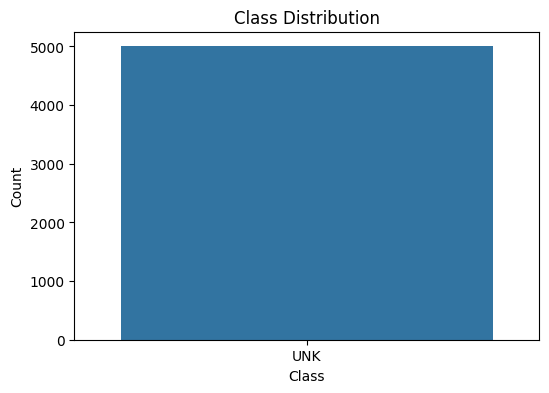

Unique values in 'reactants>reagents>production' column:
4995


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


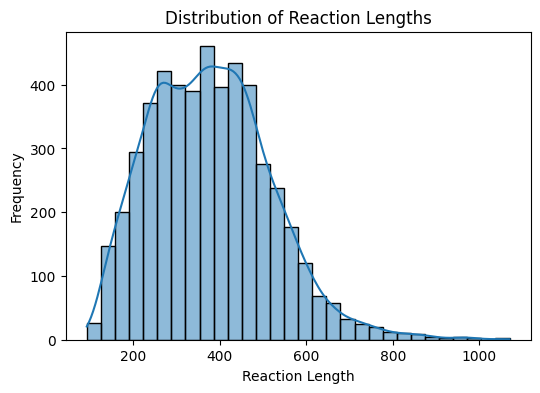

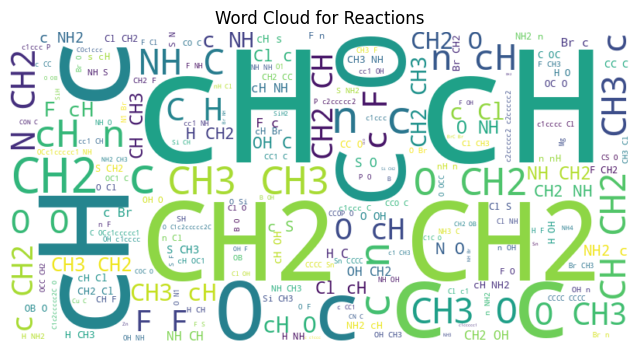

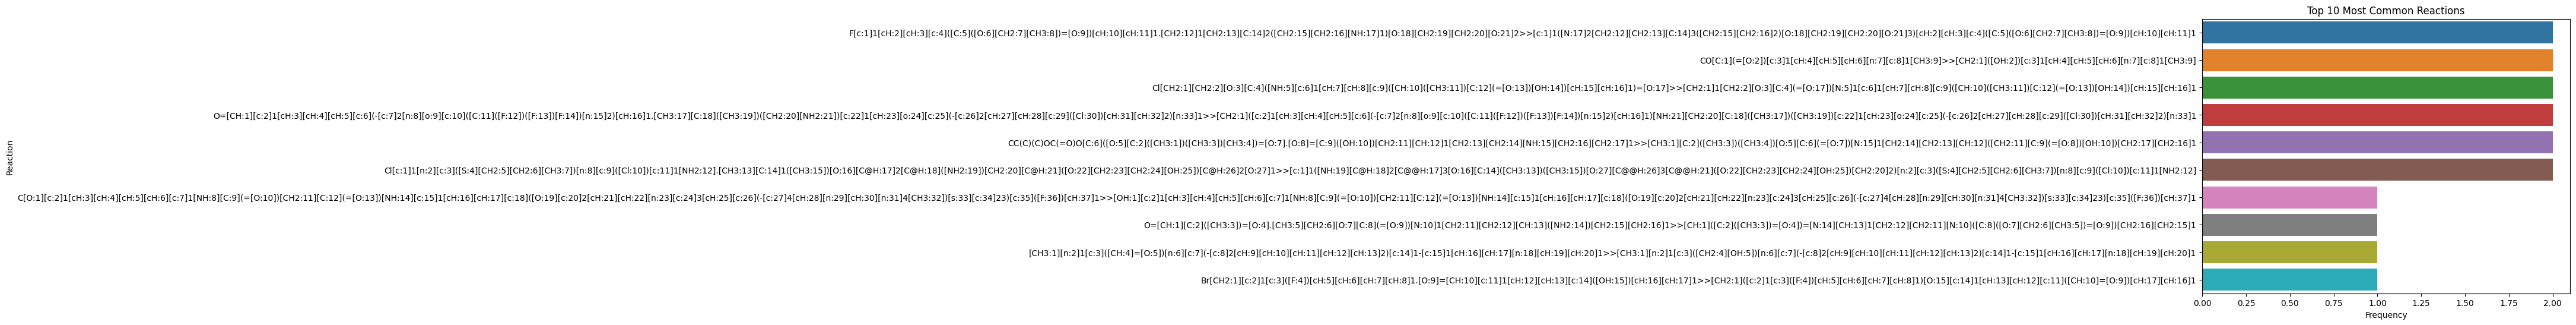

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


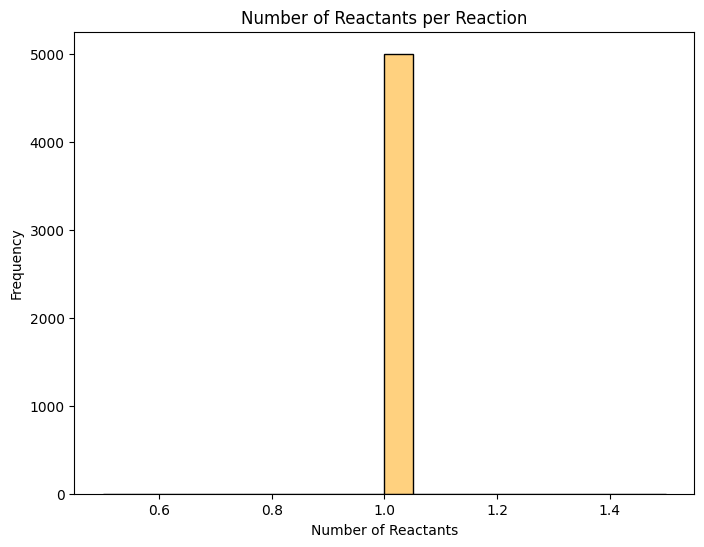

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


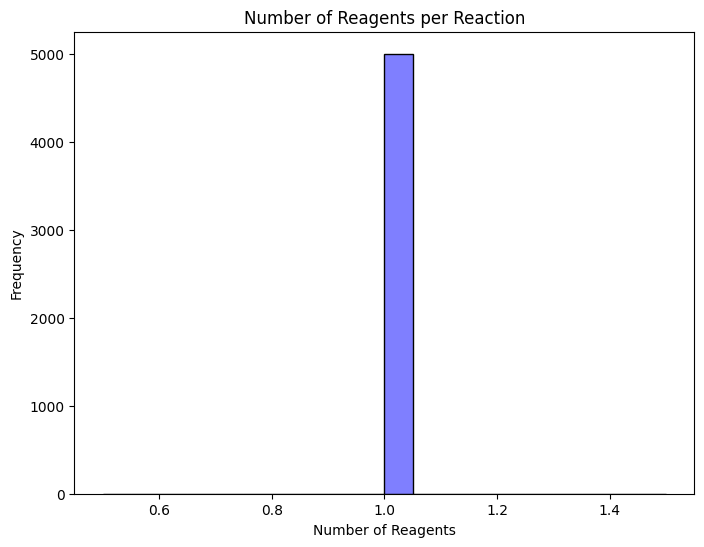

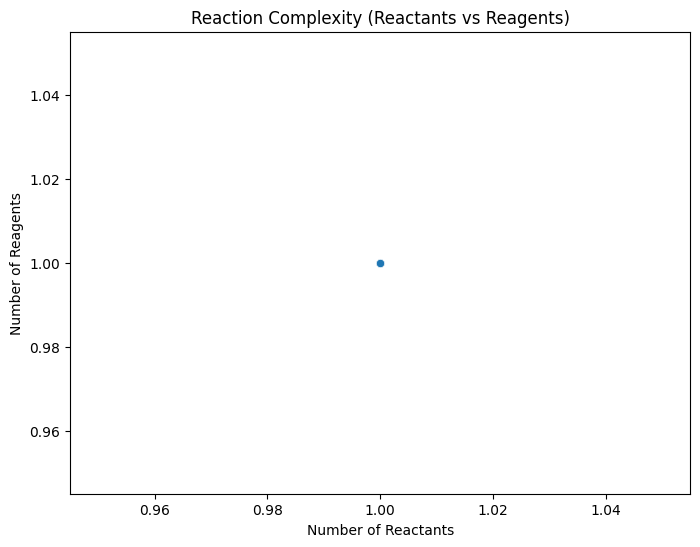

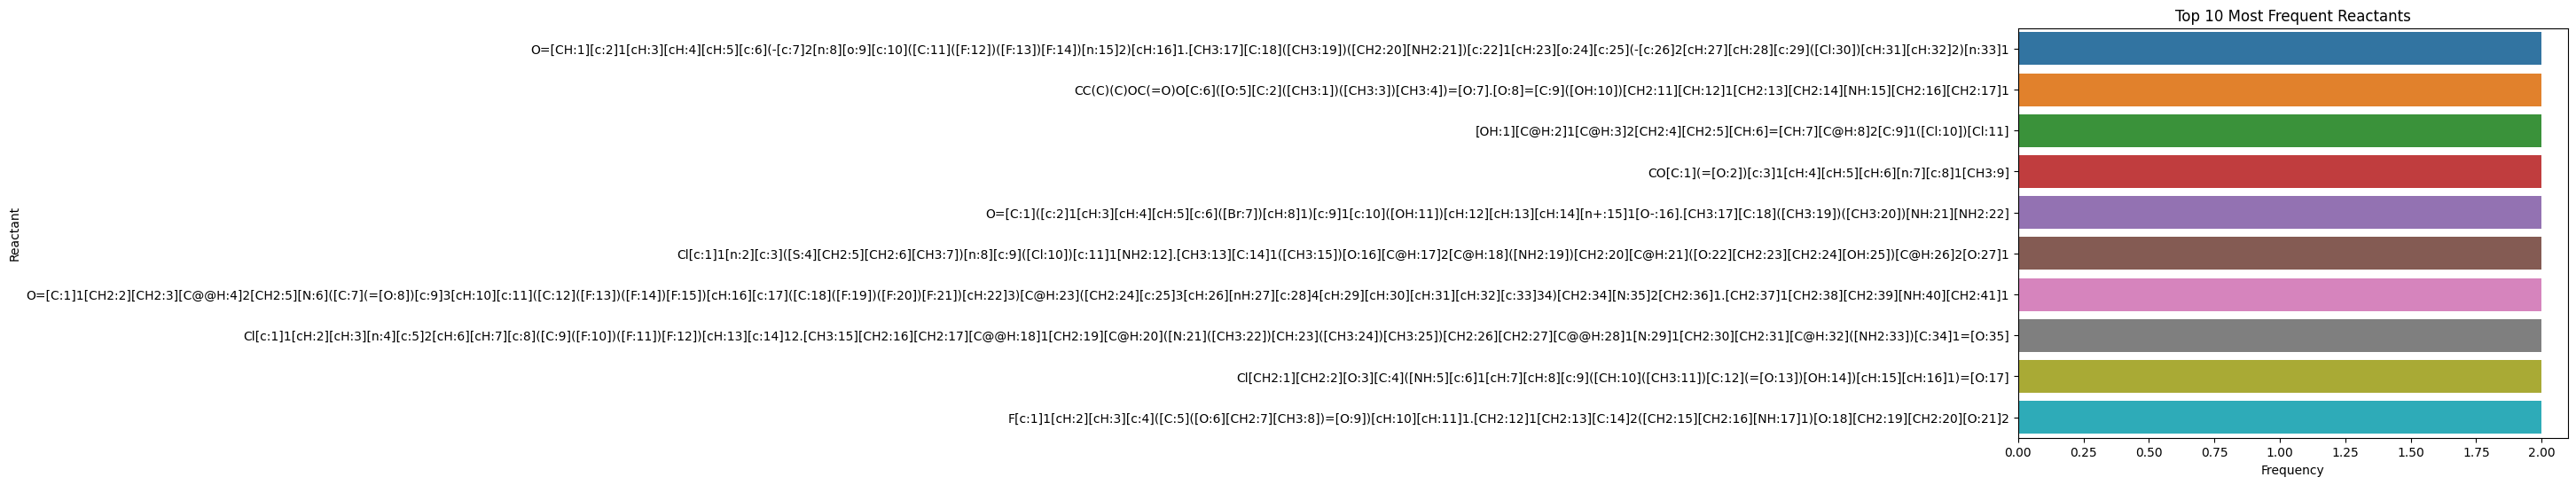

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


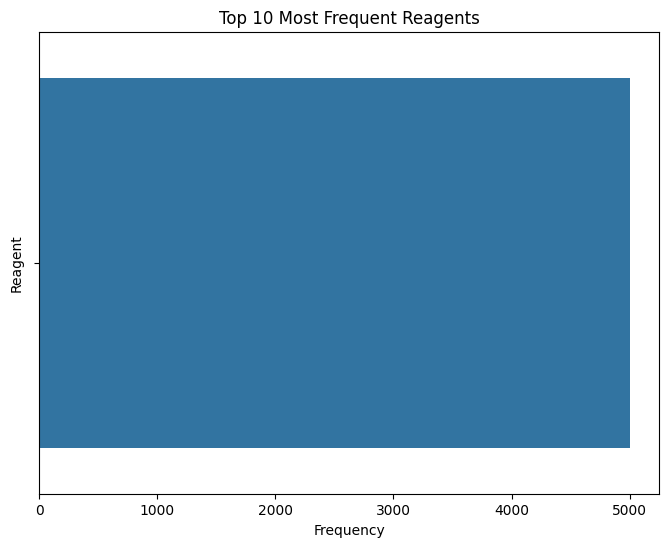

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np



# Basic Information about the dataset
print("Dataset Info:")
print(dataset.info())
print("\n")

# Show first few rows of the dataset
print("First 5 rows of the dataset:")
print(dataset.head())
print("\n")

# Check for missing values
print("Missing Values in the dataset:")
print(dataset.isnull().sum())
print("\n")

# Data distribution (value counts for 'class' column)
print("Class Distribution:")
print(dataset['class'].value_counts())

# Plot the distribution of the 'class' column
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=dataset)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Check for unique values in 'reactants>reagents>production' column
print("Unique values in 'reactants>reagents>production' column:")
print(dataset['reactants>reagents>production'].nunique())

# Reaction length distribution
dataset['reaction_length'] = dataset['reactants>reagents>production'].apply(len)

plt.figure(figsize=(6, 4))
sns.histplot(dataset['reaction_length'], bins=30, kde=True)
plt.title('Distribution of Reaction Lengths')
plt.xlabel('Reaction Length')
plt.ylabel('Frequency')
plt.show()

# Plot Word Cloud for most common words in 'reactants>reagents>production'
text = " ".join(dataset['reactants>reagents>production'].astype(str))

# Generate a word cloud
plt.figure(figsize=(8, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Reactions')
plt.axis('off')  # Hide axes
plt.show()

# Top 10 most common reactions (most frequent occurrences)
top_reactions = dataset['reactants>reagents>production'].value_counts().head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_reactions.values, y=top_reactions.index)
plt.title('Top 10 Most Common Reactions')
plt.xlabel('Frequency')
plt.ylabel('Reaction')
plt.show()

# Extracting number of reactants and reagents (reaction complexity)
dataset['num_reactants'] = dataset['reactants>reagents>production'].apply(lambda x: len(x.split('>')[0].split(',')))
dataset['num_reagents'] = dataset['reactants>reagents>production'].apply(lambda x: len(x.split('>')[1].split(',')))

plt.figure(figsize=(8, 6))
sns.histplot(dataset['num_reactants'], bins=20, kde=True, color='orange')
plt.title('Number of Reactants per Reaction')
plt.xlabel('Number of Reactants')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(dataset['num_reagents'], bins=20, kde=True, color='blue')
plt.title('Number of Reagents per Reaction')
plt.xlabel('Number of Reagents')
plt.ylabel('Frequency')
plt.show()

# Reaction complexity (reactants vs reagents)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=dataset['num_reactants'], y=dataset['num_reagents'])
plt.title('Reaction Complexity (Reactants vs Reagents)')
plt.xlabel('Number of Reactants')
plt.ylabel('Number of Reagents')
plt.show()

# Plot Most Frequent Reactants (top 10)
reactants = dataset['reactants>reagents>production'].apply(lambda x: x.split('>')[0]).value_counts().head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=reactants.values, y=reactants.index)
plt.title('Top 10 Most Frequent Reactants')
plt.xlabel('Frequency')
plt.ylabel('Reactant')
plt.show()

# Plot Most Frequent Reagents (top 10)
reagents = dataset['reactants>reagents>production'].apply(lambda x: x.split('>')[1]).value_counts().head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=reagents.values, y=reagents.index)
plt.title('Top 10 Most Frequent Reagents')
plt.xlabel('Frequency')
plt.ylabel('Reagent')
plt.show()


In [15]:
!pip install py3Dmol

In [35]:
pip install pandas rdkit


Note: you may need to restart the kernel to use updated packages.
